### Ground Truth Translations
#### Exploration and Accuracy Calculation
w266 Final Project: Crosslingual Word Embeddings

Created: 2017-12-10 RLH

Updated: 2017-12-19 RLH


In this notebook I'm exploring the format of the ground-truth translations from MUSE (linked in BaselineModels/data) and writing a function to take the embeddings for a particular language and calculate accuracy, as defined in Vulic and Moens (2015).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys  
import math
import random
import sklearn
import numpy as np
import pandas as pd
import collections
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

# tell matplotlib not to open a new window
%matplotlib inline

In [3]:
# filepaths
BASE = '/home/rhopper/W266-Fall-2017-Final-Project/BaselineModels/data/ground_truth_translations'
FPATH_ENES = BASE + '/en-es.txt' # English -> Spanish
FPATH_ENIT = BASE + '/en-it.txt' # English -> Italian
FPATH_ENNL = BASE + '/en-nl.txt' # English -> Dutch
FPATH_ENJA = BASE + '/en-ja.txt' # English -> Japanese
FPATH_ESEN = BASE + '/es-en.txt' 
FPATH_ITEN = BASE + '/it-en.txt' 
FPATH_NLEN = BASE + '/nl-en.txt'
FPATH_JAEN = BASE + '/ja-en.txt'

In [18]:
# We'll explore the English to Spanish file to get a feel for it
en_es = pd.read_csv(FPATH_ENES, sep=" ", header=None)
en_es.columns = ["en", "es"]
en_es.describe()

,en,es
count,112579,112579
unique,93083,96614
top,sing,angustia
freq,6,6


It seems like the idea of "ground truth" is complicated by the fact that some words have multiple equally-valid translations (e.g. "the").

I assume that in terms of accuracy, it counts as "accurate" if "the" is translated into any of the possible translations (in the context of this task).

In [24]:
en_es.head()

,en,es
0,the,el
1,the,las
2,the,los
3,the,la
4,and,y


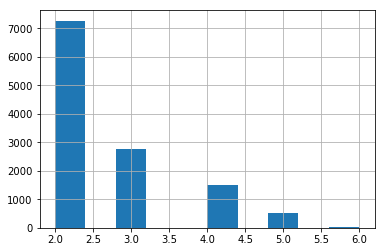

In [30]:
#How many words have more than one translation?
en_translation_counts = en_es.groupby(by='en').size()
en_translation_counts[en_translation_counts > 1].hist(bins=10)

It looks like these ground-truth translations also contain some odd values (like hex codes and text speak - "lmfao" appears).

In other circumstances I might want to strip out these odd translations but I don't think they will affect our task.

In [29]:
# Looks like a lot of proper nouns

inflex_words = en_translation_counts[en_translation_counts < 2]
print("Total: {} unique words".format(len(inflex_words)))
inflex_words.sample(10)

Total: 81020 unique words


en
nostra         1
breakbeat      1
ruthenians     1
burstyn        1
lanterne       1
temples        1
tineo          1
audits         1
tecumseh       1
cotoneaster    1
dtype: int64

### Prepending the tokens for easier comparison

Words in the corpora have a two-letter prefix that identifies the language they belong to. We need to make this edit to the languages in the ground-truth translations for easier comparison.

In [12]:
#Process English/Spanish files and prepend the respective languages
#Write prepended file out
en_es = pd.read_csv(FPATH_ENES, sep=" ", names=["en", "es"], header=None)
en_es['en'] = 'en_' + en_es['en'].astype(str)
en_es['es'] = 'es_' + en_es['es'].astype(str)
en_es.to_csv(BASE + '/en-es-clean.csv', index=None, sep=' ', mode='a')

es_en = pd.read_csv(FPATH_ESEN, sep=" ", names=["es", "en"], header=None)
es_en['es'] = 'es_' + es_en['es'].astype(str)
es_en['en'] = 'en_' + es_en['en'].astype(str)
es_en.to_csv(BASE + '/es-en-clean.csv', index=None, sep=' ', mode='a')

#Process English/Italian files and prepend the respective languages
#Write prepended file out
en_it = pd.read_csv(FPATH_ENIT, sep=" ", names=["en", "it"], header=None)
en_it['en'] = 'en_' + en_it['en'].astype(str)
en_it['it'] = 'it_' + en_it['it'].astype(str)
en_it.to_csv(BASE + '/en-it-clean.csv', index=None, sep=' ', mode='a')

it_en = pd.read_csv(FPATH_ITEN, sep=" ", names=["it", "en"], header=None)
it_en['it'] = 'it_' + it_en['it'].astype(str)
it_en['en'] = 'en_' + it_en['en'].astype(str)
it_en.to_csv(BASE + '/it-en-clean.csv', index=None, sep=' ', mode='a')

#Process English/Dutch files and prepend the respective languages
#Write prepended file out
en_nl = pd.read_csv(FPATH_ENNL, sep=" ", names=["en", "nl"], header=None)
en_nl['en'] = 'en_' + en_nl['en'].astype(str)
en_nl['nl'] = 'nl_' + en_nl['nl'].astype(str)
en_nl.to_csv(BASE + '/en-nl-clean.csv', index=None, sep=' ', mode='a')

nl_en = pd.read_csv(FPATH_NLEN, sep=" ", names=["nl", "en"], header=None)
nl_en['nl'] = 'nl_' + nl_en['nl'].astype(str)
nl_en['en'] = 'en_' + nl_en['en'].astype(str)
nl_en.to_csv(BASE + '/nl-en-clean.csv', index=None, sep=' ', mode='a')

In [13]:
#Process English/Japanese files and prepend the respective languages
#Remove 	 symbol in En/Ja files...

#Write prepended file out
en_ja = pd.read_csv(FPATH_ENJA, sep="\t", names=["en", "ja"], header=None)
en_ja['en'] = 'en_' + en_ja['en'].astype(str)
en_ja['ja'] = 'ja_' + en_ja['ja'].astype(str)
en_ja.to_csv(BASE + '/en-ja-clean.csv', index=None, sep=' ', mode='a')

ja_en = pd.read_csv(FPATH_JAEN, sep="\t", names=["ja", "en"], header=None)
ja_en['ja'] = 'ja_' + ja_en['ja'].astype(str)
ja_en['en'] = 'en_' + ja_en['en'].astype(str)
ja_en.to_csv(BASE + '/ja-en-clean.csv', index=None, sep=' ', mode='a')

In [35]:
ja_en= pd.read_csv(BASE + "/ja-en-clean.csv", sep=" ")
ja_en.head()

,ja,en
0,ja_から,en_from
1,ja_として,en_as
2,ja_日本,en_japan
3,ja_日本,en_nippon
4,ja_この,en_this


### Calculating accuracy for a predicted translation

We want $Acc_{1}$ from Vulic and Moens 2015: the number of source language words from ground truth translation pairs for which the top-ranked word cross-lingually is the correct translation

In [4]:
en_es = pd.read_csv(BASE + "/en-es-clean.txt", sep=" ")
en_es.head()

,en,es
0,en_the,es_el
1,en_the,es_las
2,en_the,es_los
3,en_the,es_la
4,en_and,es_y


In [5]:
# This is an example of the way evaluate_prediction will fit into model1.py

#We want to be able to control the verbose printing, but also to calculate accuracy whether verbose=True or not
#We can worry about the verbose issue later

if verbose and step % sim_logging_interval == 0:
    sim = self.similarity.eval()
    bli = self.evaluate_prediction()
    total_valid=[] #Track the total number of valid translations in the nearest k
    any_valid=[] #Track whether ANY of the nearest k were valid translations
    for i in xrange(len(sample)):
        word = index[sample[i]]
        top_k = 3  # number of nearest neighbors
        nearest, valid_translation = bli(source_lang, target_lang, top_k, word)
        total_valid.append(valid_translation)
        log_str = '   Nearest to %s:' % word
        for k in xrange(top_k):
            nbr = index[nearest[k]]
            log_str = '%s %s,' % (log_str, nbr)
        print(log_str)
    
    #For any_valid, we need 0/1 to calculate the mean
    for s in range(len(total_valid)):
        if total_valid[s] > 0:
            any_valid.append(1)
        else:
            any_valid.append(0)
    accuracy = (sum(any_valid) / (len(any_valid)))
    print('Successful translation rate: %d' % accuracy)

In [63]:
def evaluate_prediction(source_lang, target_lang, top_k, word):
    """
    Given example source words and the ground truth translations, 
    evaluate the number of source language words for which one of the top three predictions is the correct translation
    (fuzzy measure adopted from stricter Vulic and Moens task which requires that one predicted translation is exactly correct)
    
    Takes:
    source_lang: a two-letter string representing the source language
    target_lang: a two-letter string representing the target language
    top_k: the number of predictions we're checking for in the ground truth list
    word: the word we are interested in evaluating
    
    Returns:
    nearest: the top_k nearest neighbors of word
    valid_translation: tracks how many words in "nearest" are valid translations 
        (range 0-k, restricted by the number of translations in the ground truth list)
    """
        
    GTT_BASE = '/home/rhopper/W266-Fall-2017-Final-Project/BaselineModels/data/ground_truth_translations/' #'/home/mmillervedam/ProjectRepo/BaselineModels/data/ground_truth_translations/'
    GTT_PATH = GTT_BASE + "%s-%s-clean.txt" % (source_lang, target_lang)
    gtt = pd.read_csv(GTT_PATH, names = [source_lang, target_lang], sep=" ", header=None)
    
    
    valid_translation=0
    nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    for k in range(top_k):
        close_word = reverse_dictionary[nearest[k]]
        total_translations = (gtt[gtt[source_lang] == word])
        if close_word in total_translations[total_translations.columns[1]].values:
            valid_translation+=1
        else:
            valid_translation+=0
                
    return nearest, valid_translation    

In [67]:
##Revised version for testing
def evaluate_prediction_rev(source_lang, target_lang, nearest, top_k, word):

    GTT_BASE = '/home/rhopper/W266-Fall-2017-Final-Project/BaselineModels/data/ground_truth_translations/' #'/home/mmillervedam/ProjectRepo/BaselineModels/data/ground_truth_translations/'
    GTT_PATH = GTT_BASE + "%s-%s-clean.txt" % (source_lang, target_lang)
    gtt = pd.read_csv(GTT_PATH, names = [source_lang, target_lang], sep=" ", header=None)
    
    valid_translation=0
    #nearest = (-sim[i, :]).argsort()[1:top_k + 1]
    for k in range(top_k):
        #close_word = reverse_dictionary[nearest[k]]
        close_word = nearest[k]
        total_translations = (gtt[gtt[source_lang] == word])
        if close_word in total_translations[total_translations.columns[1]].values:
            valid_translation+=1
        else:
            valid_translation+=0
                
    return nearest, valid_translation    


source = "en"
target = "es"
nearest = ('es_pajaro', 'es_aves', 'es_ave')
word="en_bird"

evaluate_prediction_rev(source, target, nearest, 3, word)


source = "en"
target = "es"
nearest = ('es_necesito', 'es_necesidad', 'es_manzano')
word="en_need"
evaluate_prediction_rev(source, target, nearest, 3, word)

(('es_necesito', 'es_necesidad', 'es_manzano'), 2)

In [ ]:
###OLD VERSION BELOW

In [64]:
# Making a fake dataset to test on
valid_words = ['need', 'cat', 'bird', 'display']

eval_words={}
eval_words["need"] = ('mar', 'comer', 'barba') #0/3 correct
eval_words["cat"] = ('gato', 'elefante', 'perro') #1/3 correct
eval_words["display"] = ('pantalla', 'mostrar', 'espectaculo') #2/3 correct
eval_words["bird"] = ('pajaro', 'aves', 'ave') #3/3 correct

eval_words

{'bird': ('pajaro', 'aves', 'ave'),
 'cat': ('gato', 'elefante', 'perro'),
 'display': ('pantalla', 'mostrar', 'espectaculo'),
 'need': ('mar', 'comer', 'barba')}

In [79]:
def get_translation(source_lang, target_lang, sample):
    """
    Given example source words and the ground truth translations, 
    evaluate the number of source language words for which one of the top three predictions is the correct translation
    (fuzzy measure adopted from stricter Vulic and Moens task which requires that one predicted translation is exactly correct)
    
    source_lang: a two-letter string representing the source language
    target_lang: a two-letter string representing the target language
    sample: the words we are interested in evaluating
    """
        
    BASE = '/home/rhopper/W266-Fall-2017-Final-Project/BaselineModels/data/ground_truth_translations/'
    PATH = BASE + "%s-%s-clean.txt" % (source_lang, target_lang)
    gtt = pd.read_csv(PATH, names = [source_lang, target_lang], sep=" ", header=None)
    
    success=[]
    for i in xrange(len(sample)):
        word = index[sample[i]]
        top_k = 3  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]] 
            total_translations = (gtt[gtt[source_lang] == word])
            if close_word in total_translations[total_translations.columns[1]]:
                success.append(1)
            else:
                success.append(0)
                
    return success    

In [ ]:
examples

In [80]:
get_accuracy('en', 'es', examples)

1006         need
1007    necesitar
1008     necesito
1009     necesita
1010    necesidad
Name: es, dtype: object
1006         need
1007    necesitar
1008     necesito
1009     necesita
1010    necesidad
Name: es, dtype: object
1006         need
1007    necesitar
1008     necesito
1009     necesita
1010    necesidad
Name: es, dtype: object
0


0